In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn import metrics

In [1]:
# %reset -f

In [2]:
statistics_dict = {}

Functions

In [193]:
def filter_out_lower_than_10_reads(counts):
    # Calculate the mean count for each gene (row)
    mean_counts = counts.mean(axis=1)

    # Filter out rows where mean count is greater than 10
    filtered = counts[mean_counts >= 10]

    return filtered


def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


def get_pyrogen_name(sample_name_list):
    output = []
    for sample in sample_name_list:
        output.append(sample.split("_")[1])
    return output


def raw_to_rpm(DataFrame):
    outputDF = pd.DataFrame()
    for sample in DataFrame.columns:
        total_reads = DataFrame[sample].sum()
        outputDF[sample] = DataFrame[sample].apply(
            lambda x: (x / total_reads) * 1000000
        )
    return outputDF


def plot_PCA(data, title):
    # determines samplenames
    hue = []
    style = []
    for sample in data.columns:
        sample = sample.split("_")
        hue.append(sample[1])
        style.append(sample[0])

    testDF = data.transpose()
    pca = PCA(n_components=2)
    principalcomponents = pca.fit_transform(testDF)
    outputDF = pd.DataFrame(
        principalcomponents, columns=["PC0", "PC1"], index=data.columns
    )
    loadings = pd.DataFrame(
        pca.components_.transpose(), columns=["PC0", "PC1"], index=data.index
    )

    a = sns.scatterplot("PC0", "PC1", data=outputDF, hue=hue, style=style)

    a.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
    a.set_title(title)
    # print(pca.explained_variance_ratio_)
    return ()


# Accuracy: (True Positive + True Negative) / Total Predictions
# Precision: True Positive / (True Positive + False Positive)
# Recall: True Positive / (True Positive + False Negative)
# Specificity: True Negative / (True Negative + False Positive)
# F-score: 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

Load data

In [213]:
filenamelist = [
    "BA034_raw_reads.csv",
    "BA044_raw_reads.csv",
    "BA051_raw_reads.csv",
    "BA061_raw_reads.csv",
    "BA064_raw_reads.csv",
]

# loads all seq datasets
path = "~/MATseq/library/ML_models/data_exploration/support_files"


# loads metadata
all_metadata = pd.read_csv(
    os.path.join(path, "double_pyr_metadata.csv"),
    encoding="utf8",
    sep=";",
    index_col="index",
)

metadata = list(
    all_metadata[
        ((all_metadata["include_in_model"] == True))
        & (all_metadata["exclude_from_model"] == False)
    ].index
)

raw_reads_df = pd.DataFrame()
for filename in filenamelist:
    temp_df = pd.read_csv(
        os.path.join(path, filename), encoding="utf8", index_col="gene"
    )
    raw_reads_df = raw_reads_df.join(temp_df, how="right")

raw_reads_df.reset_index(inplace=True, drop=False)

# make sample names uniform
new_columns = ("&").join(list(raw_reads_df.columns))

new_columns = new_columns.replace("control", "IMDM")
new_columns = new_columns.replace("CL307", "CL-307")
new_columns = new_columns.replace("Albu", "AH1252")
new_columns = new_columns.replace("cAlb", "AH1397")
new_columns = new_columns.replace("Alb2", "AH1405")
new_columns = new_columns.replace("LPS_PGN", "LPS-PGN")
new_columns = new_columns.replace("LPS_R848", "LPS-R848")
new_columns = new_columns.replace("Pam3_PGN", "Pam3-PGN")
new_columns = new_columns.replace("Pam3_R848", "Pam3-R848")
new_columns = new_columns.replace("PAM3", "Pam3")
new_columns = new_columns.replace("Fla-ST", "Fla-St")
new_columns = new_columns.replace("TL8", "TL8-506")
new_columns = new_columns.replace("CL8", "TL8-506")

new_columns = new_columns.split("&")
raw_reads_df.columns = new_columns

included_raw_reads = raw_reads_df[metadata].copy()
# included_raw_reads["gene"] = raw_reads_df["gene"]


# sample_name_list = get_pyrogen_name(set(included_raw_reads.columns[:-1]))

# print("current samples:", list(set(sample_name_list)))

,BA060_LPS-PGN_13,BA060_LPS-PGN_14,BA060_LPS-PGN_15,BA060_LPS-PGN_16,BA060_LPS-R848_17,BA060_LPS-R848_18,BA060_LPS-R848_19,BA060_Pam3-PGN_5,BA060_Pam3-PGN_6,BA060_Pam3-PGN_7,BA060_Pam3-R848_09,BA060_Pam3-R848_10,BA060_Pam3-R848_11
0,0,0,0,0,0,2,0,0,0,1,0,0,1
1,169,186,245,52,224,200,270,179,79,169,225,200,256
2,66,79,104,30,71,56,66,84,37,89,50,53,64
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,419,479,589,148,387,401,445,398,216,381,380,365,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,0,0,0,0,0,0,0,0,0,0,0,0,0
19988,0,0,0,0,1,0,2,1,0,0,0,0,1
19989,4584,5112,7570,1878,7375,7777,8255,5591,3018,4557,8054,6816,9703
19990,4476,5075,6368,1903,5042,5175,5520,5142,2026,5136,4540,4232,4865


Split data

In [169]:
from sklearn.model_selection import StratifiedShuffleSplit

real_labels = [("_").join(i.split("_")[1:2]) for i in included_raw_reads]
included_raw_reads.loc["labels"] = real_labels
included_raw_reads_trns = included_raw_reads.transpose()

# Split the data using StratifiedShuffleSplit with stratify parameter
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=93)

# Use stratify=included_raw_reads_trns['labels'] to ensure proportional sampling
for train_index, test_index in split.split(
    included_raw_reads_trns, included_raw_reads_trns["labels"]
):
    strat_train_set = included_raw_reads_trns.iloc[train_index].copy()
    strat_test_set = included_raw_reads_trns.iloc[test_index].copy()

for set in (strat_train_set, strat_test_set):
    set.drop(["labels"], axis=1, inplace=True)

train_set = strat_train_set.T
test_set = strat_test_set.T


train_set

,BA029_LTA_20,BA028_R848_16,BA042_LPS_5,BA063_Pam3_18,BA063_LPS_5,BA046_PGN_18,BA029_CL-307_24,BA029_CL-307_22,BA046_PGN_17,BA042_IMDM_1,...,BA063_LPS_4,BA042_LPS_6,BA028_IMDM_01,BA046_CL-307_21,BA029_PGN_14,BA042_Fla-PA_17,BA029_LPS_08,BA059_IMDM_01,BA029_IMDM_02,BA029_IMDM_03
0,0,2,0,2.0,0.0,0,0,0,1,0,...,0.0,0,0,0,0,0,0,1,2,0
1,42,125,72,274.0,348.0,49,96,88,184,80,...,249.0,60,45,91,36,23,139,280,108,65
2,22,41,19,100.0,117.0,28,17,33,56,48,...,107.0,21,22,24,19,19,52,148,49,28
3,0,0,0,0.0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
4,92,242,159,552.0,668.0,288,180,135,510,181,...,488.0,165,205,204,141,88,303,668,221,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,0,0,0,0.0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
19988,0,0,0,2.0,0.0,1,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
19989,1433,3972,1797,6483.0,5844.0,1176,3201,2514,5688,2209,...,5470.0,1674,1183,3788,1253,1024,3464,7107,1915,1747
19990,1347,3335,1941,7529.0,8655.0,3645,1592,1532,4497,2601,...,6027.0,1655,2006,1779,1316,994,3584,8450,3021,2445


DESeq2 normalisation and filtration of more than 10 reads mean per gene, then zscore standardization

In [233]:
from scipy.stats import zscore as zscore

norm_train_set = to_normalize_DESeq2_style(train_set)
norm_filt_train_set = filter_out_lower_than_10_reads(norm_train_set)
z_train_set = zscore(norm_filt_train_set)
z_train_set_unfilt = zscore(norm_train_set)

norm_test_set = to_normalize_DESeq2_style(test_set)
norm_filt_test_set = filter_out_lower_than_10_reads(norm_test_set)
z_test_set = zscore(norm_filt_test_set)
z_test_set_unfilt = zscore(norm_test_set)

19992

In [ ]:
filenamelist = [
    "BA034_raw_reads.csv",
    "BA044_raw_reads.csv",
    "BA051_raw_reads.csv",
    "BA061_raw_reads.csv",
    "BA064_raw_reads.csv",
]

# loads all seq datasets
path = "~/MATseq/library/ML_models/data_exploration/support_files"


# loads metadata
all_metadata = pd.read_csv(
    os.path.join(path, "double_pyr_metadata.csv"),
    encoding="utf8",
    sep=";",
    index_col="index",
)

metadata = list(
    all_metadata[
        ((all_metadata["include_in_model"] == True))
        & (all_metadata["exclude_from_model"] == False)
    ].index
)

raw_reads_df = pd.DataFrame()
for filename in filenamelist:
    temp_df = pd.read_csv(
        os.path.join(path, filename), encoding="utf8", index_col="gene"
    )
    raw_reads_df = raw_reads_df.join(temp_df, how="right")

raw_reads_df.reset_index(inplace=True, drop=False)

# make sample names uniform
new_columns = ("&").join(list(raw_reads_df.columns))

new_columns = new_columns.replace("control", "IMDM")
new_columns = new_columns.replace("CL307", "CL-307")
new_columns = new_columns.replace("Albu", "AH1252")
new_columns = new_columns.replace("cAlb", "AH1397")
new_columns = new_columns.replace("Alb2", "AH1405")
new_columns = new_columns.replace("LPS_PGN", "LPS-PGN")
new_columns = new_columns.replace("LPS_R848", "LPS-R848")
new_columns = new_columns.replace("Pam3_PGN", "Pam3-PGN")
new_columns = new_columns.replace("Pam3_R848", "Pam3-R848")
new_columns = new_columns.replace("PAM3", "Pam3")
new_columns = new_columns.replace("Fla-ST", "Fla-St")
new_columns = new_columns.replace("TL8", "TL8-506")
new_columns = new_columns.replace("CL8", "TL8-506")

new_columns = new_columns.split("&")
raw_reads_df.columns = new_columns

included_raw_reads = raw_reads_df[metadata].copy()
# included_raw_reads["gene"] = raw_reads_df["gene"]


# sample_name_list = get_pyrogen_name(set(included_raw_reads.columns[:-1]))

# print("current samples:", list(set(sample_name_list)))

,BA060_LPS-PGN_13,BA060_LPS-PGN_14,BA060_LPS-PGN_15,BA060_LPS-PGN_16,BA060_LPS-R848_17,BA060_LPS-R848_18,BA060_LPS-R848_19,BA060_Pam3-PGN_5,BA060_Pam3-PGN_6,BA060_Pam3-PGN_7,BA060_Pam3-R848_09,BA060_Pam3-R848_10,BA060_Pam3-R848_11
0,0,0,0,0,0,2,0,0,0,1,0,0,1
1,169,186,245,52,224,200,270,179,79,169,225,200,256
2,66,79,104,30,71,56,66,84,37,89,50,53,64
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,419,479,589,148,387,401,445,398,216,381,380,365,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,0,0,0,0,0,0,0,0,0,0,0,0,0
19988,0,0,0,0,1,0,2,1,0,0,0,0,1
19989,4584,5112,7570,1878,7375,7777,8255,5591,3018,4557,8054,6816,9703
19990,4476,5075,6368,1903,5042,5175,5520,5142,2026,5136,4540,4232,4865


Split data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

real_labels = [("_").join(i.split("_")[1:2]) for i in included_raw_reads]
included_raw_reads.loc["labels"] = real_labels
included_raw_reads_trns = included_raw_reads.transpose()

# Split the data using StratifiedShuffleSplit with stratify parameter
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=93)

# Use stratify=included_raw_reads_trns['labels'] to ensure proportional sampling
for train_index, test_index in split.split(
    included_raw_reads_trns, included_raw_reads_trns["labels"]
):
    strat_train_set = included_raw_reads_trns.iloc[train_index].copy()
    strat_test_set = included_raw_reads_trns.iloc[test_index].copy()

for set in (strat_train_set, strat_test_set):
    set.drop(["labels"], axis=1, inplace=True)

train_set = strat_train_set.T
test_set = strat_test_set.T


train_set

,BA029_LTA_20,BA028_R848_16,BA042_LPS_5,BA063_Pam3_18,BA063_LPS_5,BA046_PGN_18,BA029_CL-307_24,BA029_CL-307_22,BA046_PGN_17,BA042_IMDM_1,...,BA063_LPS_4,BA042_LPS_6,BA028_IMDM_01,BA046_CL-307_21,BA029_PGN_14,BA042_Fla-PA_17,BA029_LPS_08,BA059_IMDM_01,BA029_IMDM_02,BA029_IMDM_03
0,0,2,0,2.0,0.0,0,0,0,1,0,...,0.0,0,0,0,0,0,0,1,2,0
1,42,125,72,274.0,348.0,49,96,88,184,80,...,249.0,60,45,91,36,23,139,280,108,65
2,22,41,19,100.0,117.0,28,17,33,56,48,...,107.0,21,22,24,19,19,52,148,49,28
3,0,0,0,0.0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
4,92,242,159,552.0,668.0,288,180,135,510,181,...,488.0,165,205,204,141,88,303,668,221,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,0,0,0,0.0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
19988,0,0,0,2.0,0.0,1,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
19989,1433,3972,1797,6483.0,5844.0,1176,3201,2514,5688,2209,...,5470.0,1674,1183,3788,1253,1024,3464,7107,1915,1747
19990,1347,3335,1941,7529.0,8655.0,3645,1592,1532,4497,2601,...,6027.0,1655,2006,1779,1316,994,3584,8450,3021,2445


In [217]:
from scipy.stats import zscore as zscore

norm_test_set_double_pyr = to_normalize_DESeq2_style(included_raw_reads)
z_double_pyr = zscore(norm_test_set_double_pyr)

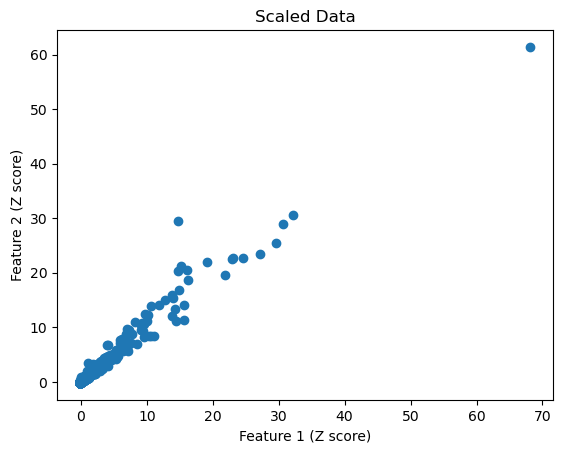

In [221]:
# z_test_set_view = z_test_set.values
# plt.scatter(z_test_set_view[:, 0], z_test_set_view[:, 1])
# plt.xlabel("Feature 1 (Z score)")
# plt.ylabel("Feature 2 (Z score)")
# plt.title("Scaled Data")
# plt.show()

In [ ]:
# real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

# y = pd.Series(real_labels, index=z_train_set.T.index)
# X = z_train_set.T

# # Define the parameter grid for Grid Search
# param_grid = {
#     "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
#     "activation": ["relu", "tanh"],
# }

# # Create the MLPC classifier
# mlpc = MLPClassifier(random_state=42, max_iter=2000)

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(estimator=mlpc, param_grid=param_grid, cv=2)
# grid_result = grid_search.fit(X, y)

# # Print the best parameters and best score
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

In [ ]:
# real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set.T]

# y = pd.Series(real_labels, index=z_train_set.index)
# X = z_train_set

# # Define the parameter grid for Grid Search
# param_grid = {
#     "hidden_layer_sizes": [(25,), (25, 50), (50,)],
#     "activation": ["relu"],
#     "alpha": [0.0001, 0.001, 0.01],
#     "solver": ["adam", "lbfgs", "sgd", "adamax", "adagrad", "rmsprop"],
# }

# # Create the MLPC classifier
# mlpc = MLPClassifier(random_state=42, max_iter=2000)

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(estimator=mlpc, param_grid=param_grid, cv=2)
# grid_result = grid_search.fit(X, y)

# # Print the best parameters and best score
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

In [ ]:
# real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

# y = pd.Series(real_labels, index=z_train_set.T.index)
# X = z_train_set.T

# # Define the parameter grid for Grid Search
# param_grid = {
#     "hidden_layer_sizes": [(60, 60, 60), (70, 70, 70), (80, 80, 80)],
#     "max_iter": [450, 500, 900],
# }

# # Create the MLPC classifier
# mlpc = MLPClassifier(random_state=42)

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(
#     estimator=mlpc, param_grid=param_grid, cv=3, scoring="f1_micro"
# )
# grid_result = grid_search.fit(X, y)


# # Print the best parameters and best score
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

In [ ]:
# real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

# y = pd.Series(real_labels, index=z_train_set.T.index)
# X = z_train_set.T

# # Define the parameter grid for Grid Search
# param_grid = {
#     "hidden_layer_sizes": [(60, 60, 60), (70, 70, 70), (80, 80, 80)],
#     "max_iter": [450, 500, 900],
# }

# Create the MLPC classifier
# mlpc = MLPClassifier(random_state=42)

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(
#     estimator=mlpc, param_grid=param_grid, cv=3, scoring="f1_micro"
# )
# grid_result = grid_search.fit(X, y)


# # Print the best parameters and best score
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

In [ ]:
# grid_search.best_estimator_

In [ ]:
# cvres = grid_search.cv_results_
# cvres

In [ ]:
# real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

# y = pd.Series(real_labels, index=z_train_set.T.index)
# X = z_train_set.T

# # Define the parameter grid for Grid Search
# param_grid = {"hidden_layer_sizes": [(70, 70, 70, 70)], "max_iter": [450, 475, 490]}

# # Create the MLPC classifier
# mlpc = MLPClassifier(random_state=42)

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(estimator=mlpc, param_grid=param_grid, cv=4)
# grid_result = grid_search.fit(X, y)


# # Print the best parameters and best score
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

In [ ]:
# with open("MATseq_MLPC.model", "rb") as file:
#     loaded_model = pickle.load(file)

In [ ]:
# print("Hidden Layer Sizes:", loaded_model.hidden_layer_sizes)
# print("Activation Function:", loaded_model.activation)
# print("Learning Rate:", loaded_model.learning_rate)
# print("Max Iterations:", loaded_model.max_iter)


# # Get the parameters of the model
# model_params = loaded_model.get_params()

# # Print the parameters
# print(model_params)

In [ ]:
# from sklearn.model_selection import LeaveOneOut

# # Create a new DataFrame with the original index as a column
# real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

# y = pd.Series(real_labels, index=z_train_set.T.index)
# X = z_train_set.T

# loo = LeaveOneOut()
# predicted_labels = []

# for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # Create and train the MLPC classifier
#     model = MLPClassifier(
#         random_state=42,
#         hidden_layer_sizes=(70, 70, 70, 70),
#         max_iter=450,
#         solver="adam",
#     )
#     model.fit(X_train, y_train)

#     # Make predictions on the test fold
#     y_pred = model.predict(X_test)
#     predicted_labels.append(y_pred[0])  # Append the predicted label for this fold

In [ ]:
# name = "MLPC 4 layers of 70, 450_iter"
# evaluate_model(name=name, real_labels=real_labels, predicted_labels=predicted_labels)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.neural_network import MLPClassifier
# from scipy.stats import randint, uniform

# # Define the hyperparameter space with their corresponding distributions
# param_dist = {
#     "hidden_layer_sizes": [(70,), (100,), (50, 50), (100, 70)],
#     "activation": ["relu", "tanh"],
#     "learning_rate": ["constant", "adaptive"],
#     "alpha": uniform(0.0001, 0.1),  # Uniform distribution between 0.0001 and 0.1
#     "beta_1": uniform(0.8, 0.99),  # Uniform distribution between 0.8 and 0.99
#     "max_iter": [400, 450, 600],
# }

# # Create the MLPC classifier
# mlpc = MLPClassifier(random_state=42)

# # Create RandomizedSearchCV with the hyperparameter space and number of iterations
# random_search = RandomizedSearchCV(
#     estimator=mlpc,
#     param_distributions=param_dist,
#     n_iter=10,  # Number of random combinations to try
#     cv=3,  # Cross-validation folds
#     random_state=42,
# )

# # Perform random search with cross-validation
# random_search.fit(X_train, y_train)

# # Get the best hyperparameters and their corresponding accuracy
# best_params = random_search.best_params_
# best_accuracy = random_search.best_score_

# print("Best Parameters: ", best_params)
# print("Best Accuracy: ", best_accuracy)

In [234]:
from sklearn.metrics import make_scorer, f1_score

real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set_unfilt]

y = pd.Series(real_labels, index=z_train_set_unfilt.T.index)
X = z_train_set_unfilt.T

# Define the hyperparameter space with their corresponding distributions
param_grid = {
    "activation": ["relu"],
    "alpha": [0.0001, 0.001],
    "batch_size": ["auto"],
    "beta_1": [0.9],
    "beta_2": [0.999],
    "early_stopping": [False],
    "epsilon": [1e-08],
    "hidden_layer_sizes": [(100,)],
    "learning_rate": ["constant"],
    "learning_rate_init": [0.001],
    "max_fun": [15000],
    "max_iter": [600],
    "momentum": [0.9],
    "n_iter_no_change": [10],
    "nesterovs_momentum": [True],
    "power_t": [0.5],
    "random_state": [0],
    "shuffle": [True],
    "solver": ["adam"],
    "tol": [0.0001],
    "validation_fraction": [0.1],
    "verbose": [False],
    "warm_start": [False],
}

# Create the MLPC classifier
mlpc = MLPClassifier(random_state=42)

# Define the scoring function as F1-score with macro averaging
scoring = make_scorer(f1_score, average="macro")

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=mlpc, param_grid=param_grid, cv=2, scoring=scoring)
grid_result = grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters: ", grid_result.best_params_)
print("Best F1-score: ", grid_result.best_score_)

Best Parameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 600, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Best F1-score:  0.45035612535612535


In [237]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set_unfilt]

y = pd.Series(real_labels, index=z_train_set_unfilt.T.index)
X = z_train_set_unfilt.T

# Define the best parameters
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

# Create the MLPClassifier with the best parameters
mlpc = MLPClassifier(**params)

# Fit the classifier to your data (X_train and y_train)
mlpc.fit(X, y)

MLPClassifier(max_iter=600, random_state=0)

In [244]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set_unfilt]

y = pd.Series(real_labels, index=z_train_set_unfilt.T.index)
X = z_train_set_unfilt.T


loo = LeaveOneOut()
predicted_labels = []

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the Gaussian Naive Bayes classifier
    model = mlpc
    model.fit(X_train, y_train)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])  # Append the predicted label for this fold

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

In [248]:
real_labels

['LTA',
 'R848',
 'LPS',
 'Pam3',
 'LPS',
 'PGN',
 'CL-307',
 'CL-307',
 'PGN',
 'IMDM',
 'R848',
 'IMDM',
 'R848',
 'LPS',
 'CRX-527',
 'IMDM',
 'CRX-527',
 'IMDM',
 'CRX-527',
 'LPS',
 'IMDM',
 'IMDM',
 'LPS',
 'CL-307',
 'IMDM',
 'Pam3',
 'Pam3',
 'CRX-527',
 'LPS',
 'CL-307',
 'R848',
 'Pam3',
 'PGN',
 'IMDM',
 'Pam3',
 'IMDM',
 'Fla-PA',
 'LPS',
 'CRX-527',
 'CRX-527',
 'LPS',
 'LTA',
 'LPS',
 'LPS',
 'IMDM',
 'CL-307',
 'PGN',
 'Fla-PA',
 'LPS',
 'IMDM',
 'IMDM',
 'IMDM']

In [1]:
name = "MLPC IMDM excluded"
mlps_performance = evaluate_model(name, real_labels, predicted_labels)

NameError: name 'evaluate_model' is not defined

Test set 

In [250]:
mlps_performance

{"MLPC Bruno's with unfilt data test set (seed=93))": {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'Specificity': 1.0,
  'F1 Score': 1.0,
  'Confusion Matrix': array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 3, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 3, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1]])},
 "MLPC Bruno's with double pyrogen samples)": {'Accuracy': 0.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'Specificity': 0.0,
  'F1 Score': 0.0,
  'Confusion Matrix': array([[0, 0, 0, 0, 0, 0],
         [4, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 3],
         [3, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 3],
         [0, 0, 0, 0, 0, 0]])},
 'MLPC unfiltered train set': {'Accuracy': 0.40384615384615385,
  'Precision': 0.2616487455197133,
  'Recall': 0.2564102564102564,
  'Specificity'

In [238]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_test_set_unfilt]

# Create a new DataFrame with the original index as a column
y = pd.Series(real_labels, index=z_test_set_unfilt.T.index)
X = z_test_set_unfilt.T

predicted_labels = mlpc.predict(X)

In [239]:
df_summary = pd.DataFrame()
df_summary["real labels"] = y
df_summary["predicted labels"] = predicted_labels
df_summary

,real labels,predicted labels
BA029_LTA_19,LTA,LPS
BA046_CRX-527_10,CRX-527,LPS
BA046_PGN_20,PGN,LPS
BA046_IMDM_2,IMDM,LPS
BA028_Pam3_10,Pam3,LPS
BA028_LPS_05,LPS,LPS
BA042_Fla-PA_18,Fla-PA,LPS
BA028_LPS_07,LPS,LPS
BA059_IMDM_03,IMDM,LPS
BA028_IMDM_02,IMDM,LPS


In [240]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_double_pyr]

# Create a new DataFrame with the original index as a column
y = pd.Series(real_labels, index=z_double_pyr.T.index)
X = z_double_pyr.T

predicted_labels = mlpc.predict(X)

Model: MLPC Bruno's with unfilt data test set (seed=93))
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Specificity: 1.0
F1 Score: 1.0
Confusion Matrix: [[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]
Model: MLPC Bruno's with double pyrogen samples)
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Specificity: 0.0
F1 Score: 0.0
Confusion Matrix: [[0 0 0 0 0 0]
 [4 0 0 0 0 0]
 [0 0 0 0 0 3]
 [3 0 0 0 0 0]
 [0 0 0 0 0 3]
 [0 0 0 0 0 0]]
Model: MLPC unfiltered train set
Accuracy: 0.40384615384615385
Precision: 0.2616487455197133
Recall: 0.2564102564102564
Specificity: 0.2564102564102564
F1 Score: 0.22159975101151572
Confusion Matrix: [[ 0  0  0  0  5  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  4  9  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  5  0 

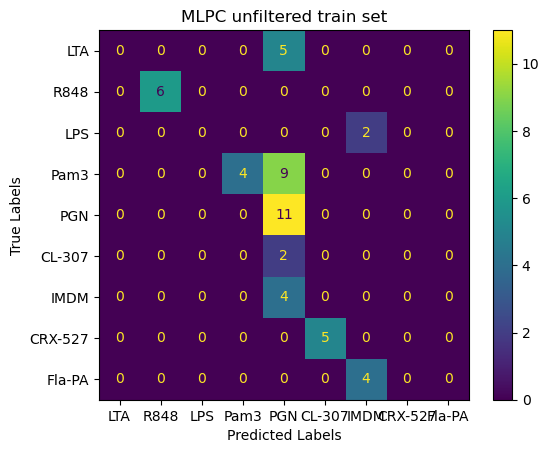

In [251]:
for model, model_stats in statistics_dict.items():
    print(f"Model: {model}")
    for metric, value in model_stats.items():
        print(f"{metric}: {value}")

    class_labels = y.unique()
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=statistics_dict[model]["Confusion Matrix"],
        display_labels=class_labels,
    )

cm_display.plot()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"{model}")
plt.show()

In [1]:
statistics_dict

NameError: name 'statistics_dict' is not defined

In [ ]:
# import csv

# # Save the dictionary to a CSV file
# csv_file = "hypertuning differences.csv"
# class_labels = y.unique()

# with open(csv_file, "w", newline="") as f:
#     writer = csv.writer(f)
#     for key, value in statistics_dict.items():
#         writer.writerow([key, value])

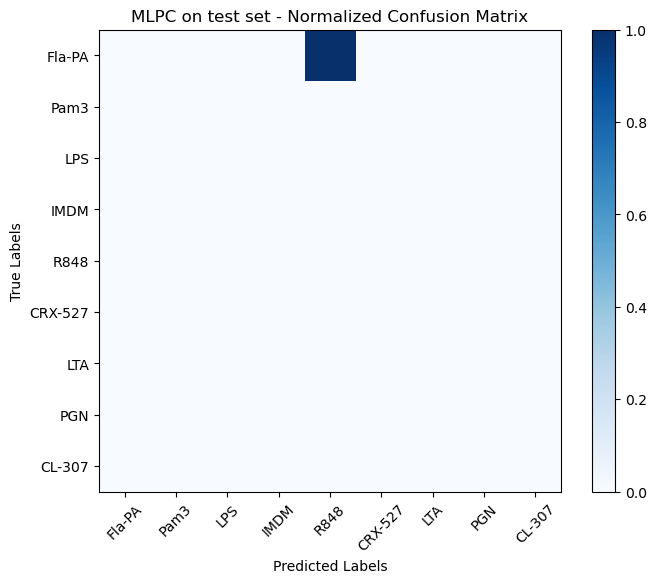

In [111]:
# name = "MLPC on test set"

# cm = metrics.confusion_matrix(real_labels, predicted_labels)
# row_sums = cm.sum(axis=1, keepdims=True)
# norm_cm = cm / row_sums
# np.fill_diagonal(norm_cm, 0)

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(8, 6))
# plt.imshow(norm_cm, cmap="Blues", interpolation="nearest")
# plt.colorbar()
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title(f"{name} - Normalized Confusion Matrix")
# plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
# plt.yticks(np.arange(len(class_labels)), class_labels)
# plt.show()